In [2]:
from nbdev import *

# Cell count analysis

In [1]:
# %load common_.py
from common import *

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
import glob
import multiprocessing

In [5]:
DIR = "/data/weizmann/EhV/high_time_res"

In [8]:
data = {
    "index": [],
    "file": [],
}

classes = ["coi"]
for c in classes:
    data.update({c: []})

In [7]:
def func(a):
    idx = pandas.read_csv(a, index_col=0, skiprows=1, delimiter="\t").index.values.tolist()
    
    f = a.replace("_ALL", "_COI")
    focused_idx = pandas.read_csv(f, index_col=0, skiprows=1, delimiter="\t").index.values.tolist()
    
    labels = [i in focused_idx for i in idx]
    
    return pandas.DataFrame(
        dict(
            index = idx,
            file = [f]*len(idx),
            coi = labels
        )
    )

with multiprocessing.Pool(processes=12) as pool:
    res = []
    for a in glob.glob(os.path.join(DIR, "**", "*_ALL.txt"), recursive=True):
        res.append((a, pool.apply_async(func, (a,))))
        
    logger.info("Submitted %d" % len(res))

    dfs = []
    for a, r in res:
        dfs.append(r.get())
        logger.info(a)
        
df = pandas.concat(dfs).set_index("index") 

INFO:__main__:Submitted 120
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C1_T0_49_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C1_T11_55_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C1_T13_56_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C1_T15_57_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C1_T3_50_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C1_T4_51_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C1_T5_52_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C1_T6_53_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C1_T7_54_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C2_T0_58_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C2_T11_64_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C2_T13_65_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C2_T3_59_ALL.txt
INFO:__main__:/data/weizmann/EhV/high_time_res/Ctrl/C2_T4_60_ALL.txt
I

In [47]:
df["replicate"] = df["file"].apply(lambda a: os.path.split(a)[-1].split("_")[0])
df["timepoint"] = df["file"].apply(lambda a: os.path.split(a)[-1].split("_")[1])
df["group"] = df["replicate"].apply(lambda a: a[0])

In [12]:
df["coi"].sum() / len(df)

0.3646997207446074

<AxesSubplot:xlabel='replicate', ylabel='count'>

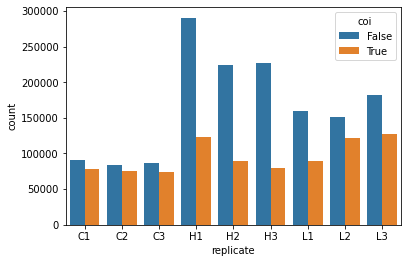

In [45]:
seaborn.countplot(data=df, x="replicate", hue="coi")

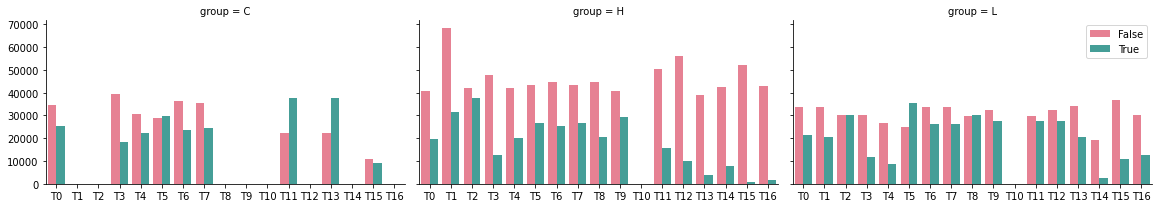

In [70]:
grid = seaborn.FacetGrid(data=df, col="group", aspect=1.8)
grid.map_dataframe(seaborn.countplot, x="timepoint", palette="husl", hue="coi", order=["T%d" % i for i in range(17)])
grid.axes[0][-1].legend()

In [17]:
timepoint_df = df.groupby("timepoint").sum()
timepoint_df["size"] = df.groupby("timepoint").size()

In [26]:
avg_fraction = (timepoint_df["coi"] / timepoint_df["size"]).mean()

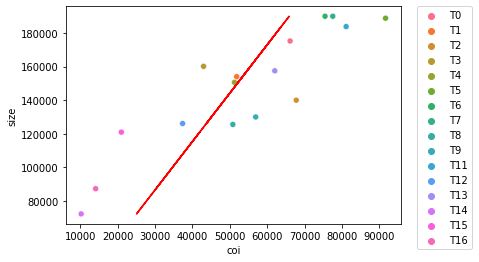

In [39]:
ax = seaborn.scatterplot(data=timepoint_df, x="coi", y="size", hue="timepoint", hue_order=["T%d" % i for i in range(17) if i != 10])
ax.plot(timepoint_df["size"]*avg_fraction, timepoint_df["size"], color="red")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)